In [1]:
import sys
sys.path.insert(0, "../")
from chunkgfn.datamodules.rna_binding import RNABindingModule
from chunkgfn.algo.tb_gfn import TBGFN
from chunkgfn.algo.a2c import A2C
from chunkgfn.algo.random_sampler import RandomSampler
from torch.distributions import Categorical
from scipy.stats import linregress, spearmanr
from einops import repeat, rearrange

import torch
from tqdm.notebook import tqdm
import lightning as L
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
from addict import Dict
import numpy as np
import wandb
from datetime import datetime

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update(
    {
        "font.serif": [
            "Computer Modern Roman",
            "Times New Roman",
            "Utopia",
            "New Century Schoolbook",
            "Century Schoolbook L",
            "ITC Bookman",
            "Bookman",
            "Times",
            "Palatino",
            "Charter",
            "serif" "Bitstream Vera Serif",
            "DejaVu Serif",
        ]
    }
)

In [2]:
def calculate_mean_std(iteration_key, value_key, *dicts):
    key_value = {}
    all_iterations = set()
    for i, d in enumerate(dicts):
        iterations = d[iteration_key]
        values = d[value_key]

        key_value[i] = {k: v for (k,v) in zip(iterations, values)}
        all_iterations = all_iterations.union(set(iterations))
    
    all_iterations = sorted(all_iterations)
    mean = []
    std = []
    for i in all_iterations:
        values = [key_value[j][i]  for j in key_value if i in key_value[j]]
        mean.append(np.mean(values))
        std.append(np.std(values))
    return all_iterations, mean, std

def get_library_embeddings(sampler, env):
    """Produce embedding for all actions in the library.
    Returns:
        library_embeddings (torch.Tensor[n_actions, action_embedding]): Embeddings for all actions.
    """
    action_indices = env.action_indices
    library_embeddings = []
    for action, indices in action_indices.items():
        library_embeddings.append(
            sampler.action_embedder(
                torch.LongTensor(indices).to(sampler.device).unsqueeze(0)
            )
        )
    library_embeddings = torch.cat(library_embeddings, dim=0)
    return library_embeddings

def get_forward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
    """Get the forward logits for the given state.
    Args:
        state (torch.Tensor[batch_size, *state_shape]): State.
    Return:
        logits (torch.Tensor[batch_size, n_actions]): Forward logits.
    """
    if algo.forward_policy is None:
        bs = state.shape[0]
        logits = torch.zeros(bs, env.n_actions).to(state.device)
        return logits
    action_embedding = algo.forward_policy(env.preprocess_states(state))
    dim = action_embedding.shape[-1]
    library_embeddings = get_library_embeddings(algo, env)
    logits = torch.einsum("bd, nd -> bn", action_embedding, library_embeddings) / (
        dim**0.5
    )  # Same as in softmax
    return logits

def get_backward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
        """Get the forward logits for the given state.
        Args:
            state (torch.Tensor[batch_size, *state_shape]): State.
        Return:
            logits (torch.Tensor[batch_size, n_actions]): Forward logits.
        """
        action_embedding = algo.backward_policy(env.preprocess_states(state))
        dim = action_embedding.shape[-1]
        library_embeddings = get_library_embeddings(algo, env)
        logits = torch.einsum("bd, nd -> bn", action_embedding, library_embeddings) / (
            dim**0.5
        )  # Same as in softmax
        return logits

In [53]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "prod"})
columns = ["_step", 'train/num_modes', 'train/num_visited', 'train/logreward', 'train/trajectory_length', 'trainer/global_step', "epoch"]

# Group runs by algorithm and then length
experiments = Dict()
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    summary["id"] = run.id
    config = run.config
    
    algo = config["algo"]["_target_"].lower()
    task = config["environment"]["task"]

    if "a2c" in algo:
        algorithm = "A2C"
    elif "tbgfn" in algo:
        algorithm = "GFN"
    elif "random" in algo:
        algorithm = "Random Sampler"
    else:
        raise Exception("can't recognize algorithm")
    
    if "chunk" not in name:
        chunk_type = "No Chunk"
    elif "chunk_replacement" in name:
        chunk_type = "Chunking w/ Replacement"
    elif "chunk" in name:
        chunk_type = "Chunking Basic"

    if len(experiments[task][algorithm][chunk_type]) == 0:
        experiments[task][algorithm][chunk_type] = [summary]
    else:
        experiments[task][algorithm][chunk_type].append(summary)

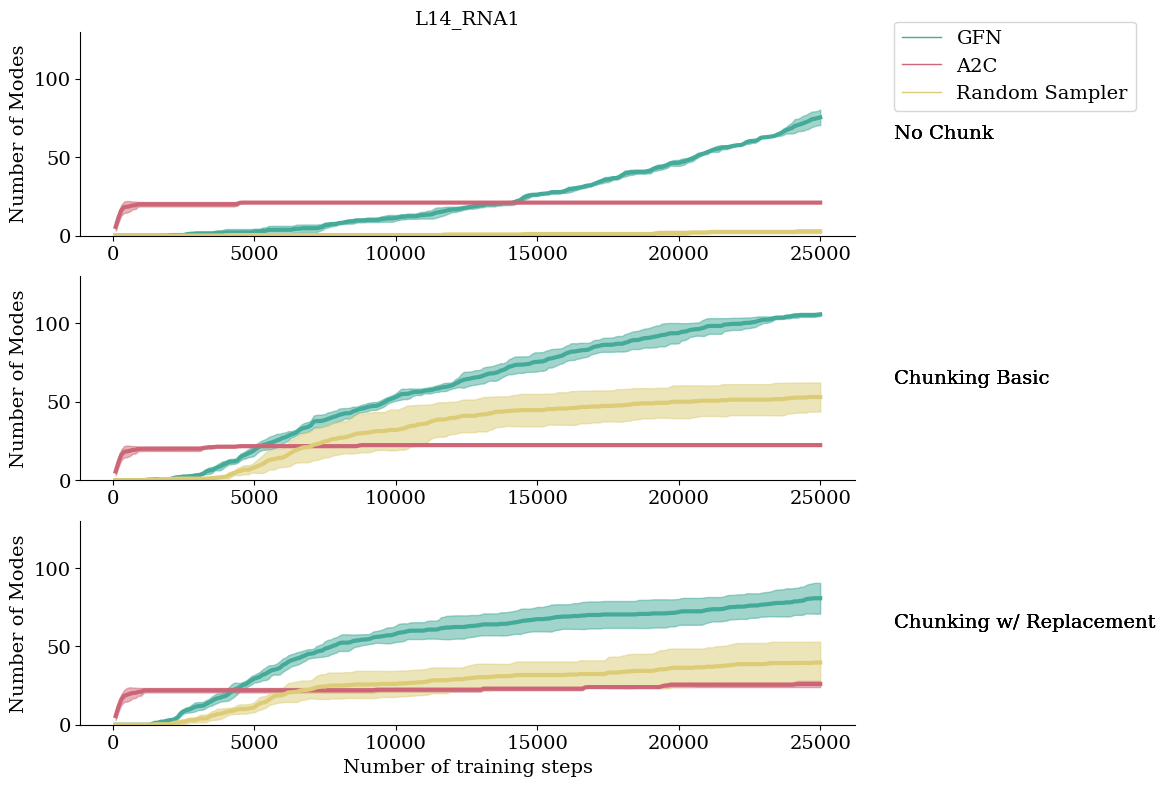

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):
 
        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
        
        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)

        ax[i].set_ylim(0,130)
        
        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")
        
        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Number of Modes")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=1, linestyle='-', label='Random Sampler')
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


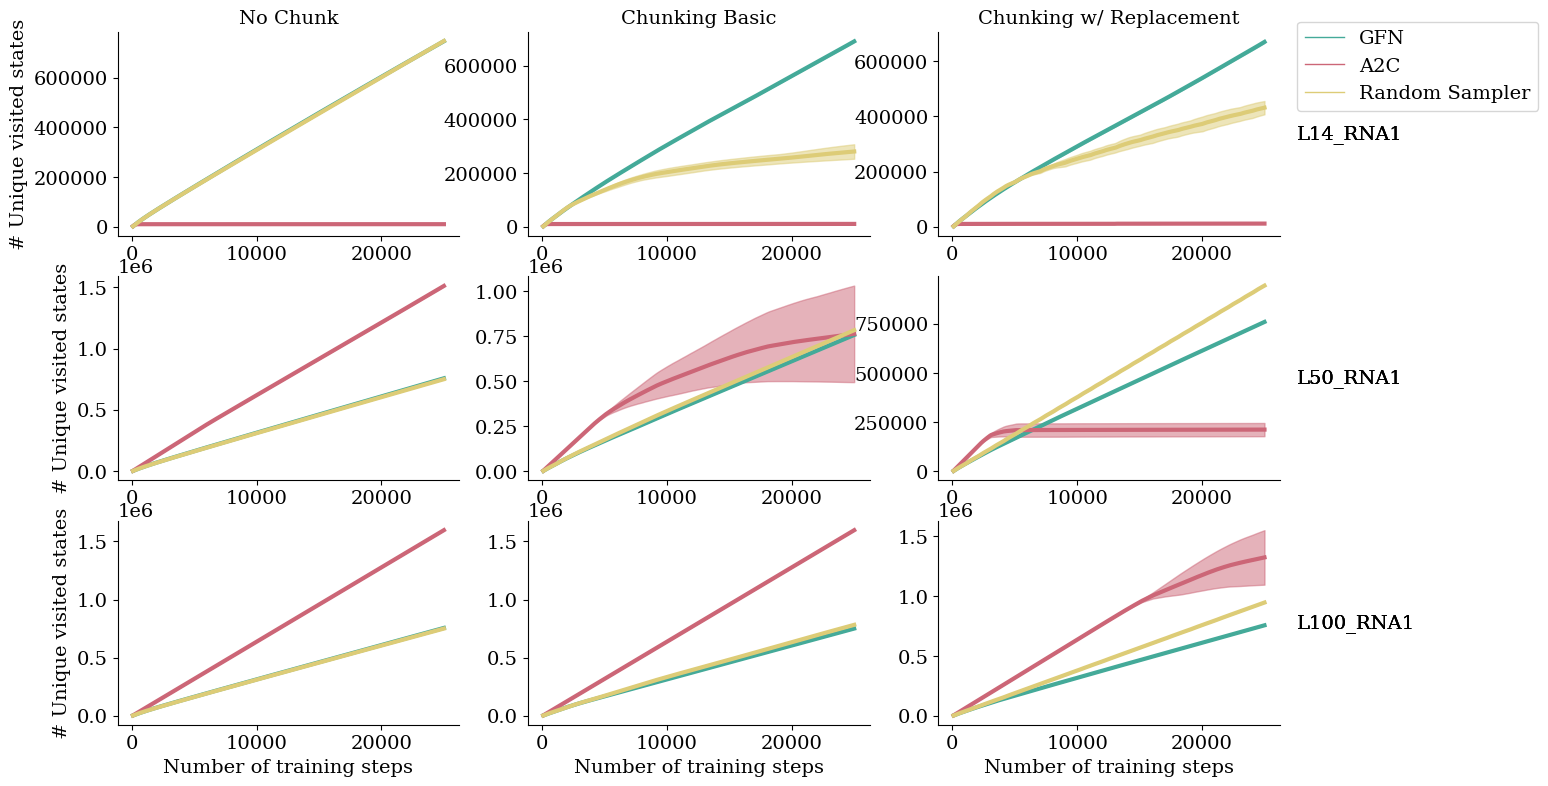

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):
    
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_visited", *experiments[task][algorithm][chunk_type])


            ax[i,j].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
            ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)
            
            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")
            
            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("# Unique visited states")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)


legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=1, linestyle='-', label='Random Sampler')
]

# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


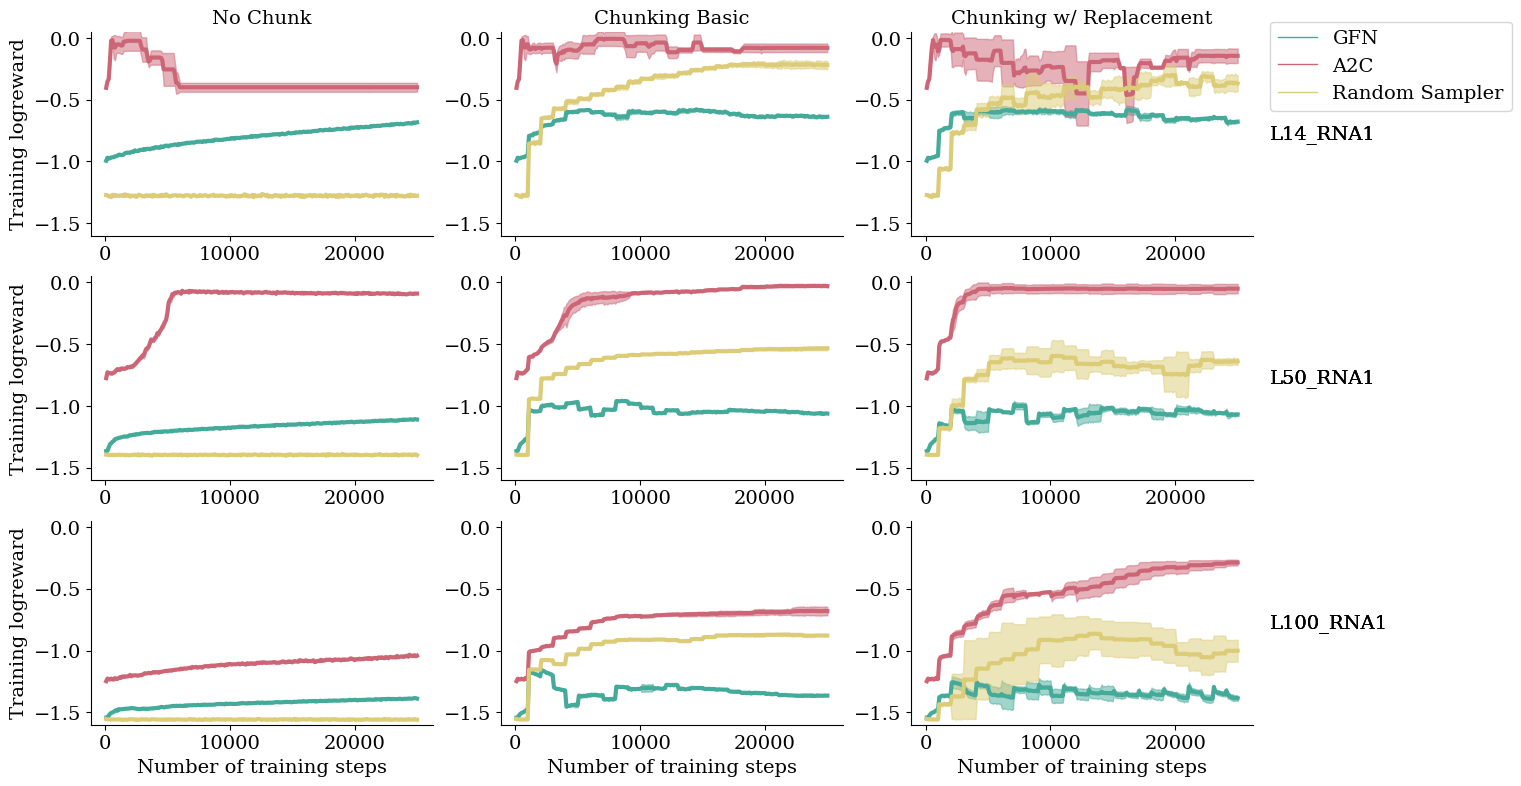

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):
    
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/logreward", *experiments[task][algorithm][chunk_type])


            ax[i,j].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
            ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)
            
            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")
            
            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("Training logreward")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)

            ax[i,j].set_ylim(-1.6, 0.05)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=1, linestyle='-', label='Random Sampler')
]

# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


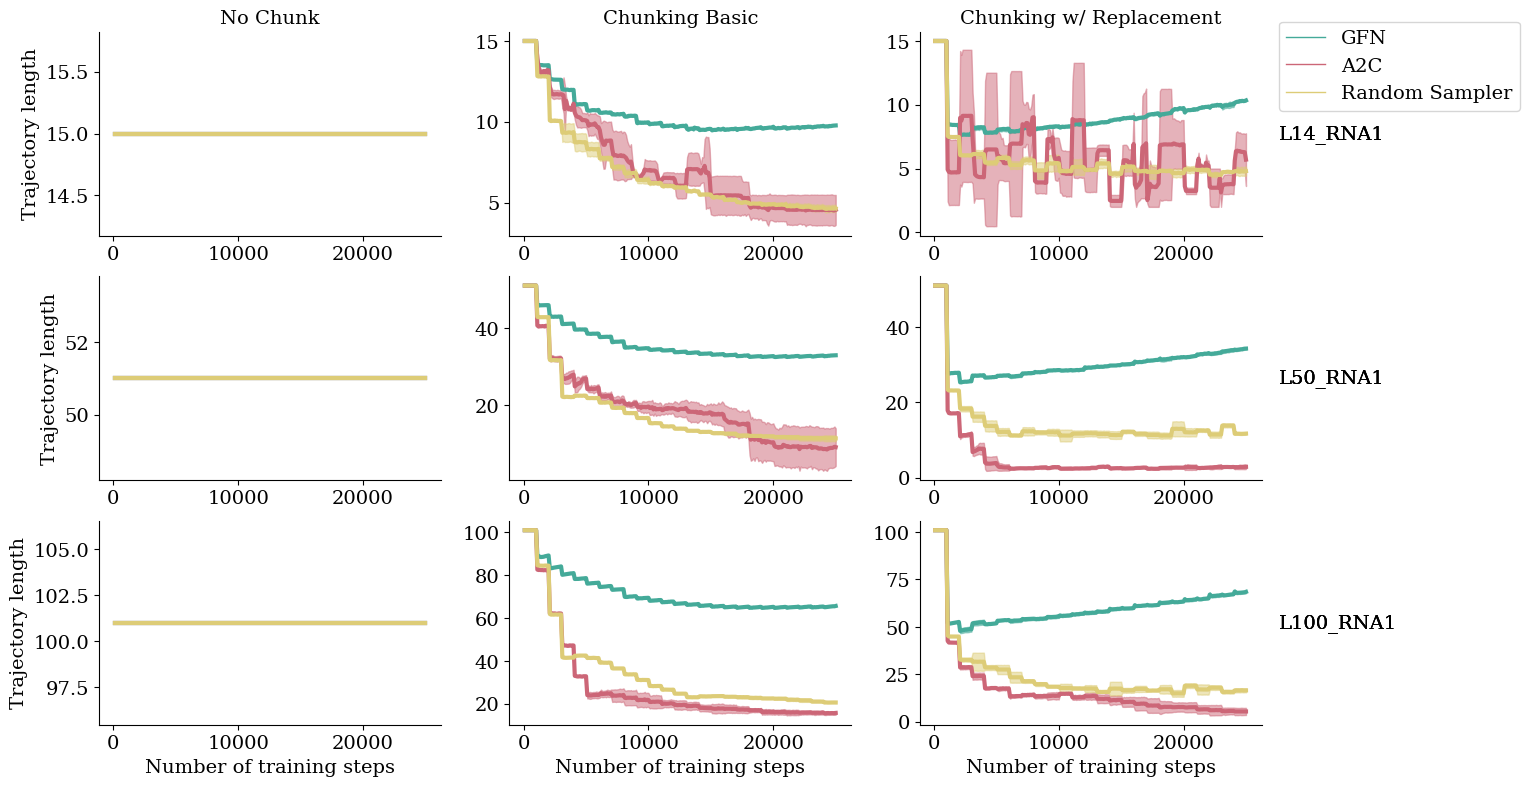

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):
    
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/trajectory_length", *experiments[task][algorithm][chunk_type])


            ax[i,j].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
            ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)
            
            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")
            
            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("Trajectory length")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)

            

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=1, linestyle='-', label='Random Sampler')
]

# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


# RNA14, Analysis of the sampler

In [9]:
def sample_trajectories(n_trajectories, sampler, env):
    with torch.no_grad():
        batch_size=n_trajectories
        s0 = env.s0.to(sampler.device)
        state = repeat(s0, " ... -> b ...", b=batch_size)
        bs = state.shape[0]

        # Start unrolling the trajectories
        actions = []
        trajectories = []
        dones = []
        done = torch.zeros((bs)).to(state).bool()
        trajectory_length = (
            torch.zeros((bs)).to(state).long()
        )  # This tracks the length of trajetcory for each sample in the batch
        while not done.all():
            logits_pf = get_forward_logits(state, sampler, env)
            valid_actions_mask = env.get_forward_mask(state)

            logits_pf = torch.where(
                valid_actions_mask,
                logits_pf,
                torch.tensor(-1e20).to(logits_pf),
            )


            cat = Categorical(logits=logits_pf)

            act = cat.sample()

            new_state, done = env.forward_step(state, act)
            trajectory_length += ~done  # Increment the length of the trajectory for each sample in the batch as long it's not done.

            actions.append(act)
            trajectories.append(state)
            dones.append(done.clone())

            state = new_state.clone()

        logreward = env.compute_logreward(state).to(
                state.device
        )
        trajectories.append(state)
        dones.append(torch.ones((bs)).to(state).bool())
        trajectories = torch.stack(trajectories, dim=1)
        actions = torch.stack(actions, dim=1)
        dones = torch.stack(dones, dim=1)

    return logreward, state, trajectories, dones, actions

In [10]:
logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()
modules = {
    "GFN": TBGFN,
    "A2C": A2C,
    "Random Sampler": RandomSampler
}
for algo in tqdm(experiments["L14_RNA1"]):
    for chunk_type in experiments["L14_RNA1"][algo]:
        run_id = experiments["L14_RNA1"][algo][chunk_type][0]["id"]
        
        sampler = modules[algo].load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()

        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        avg_top100_distance[algo][chunk_type] = 0.5*torch.cdist(final_state.view(final_state.shape[0],-1), final_state.view(final_state.shape[0],-1), p=1.0).mean()
        logrewards[algo][chunk_type] = logreward
        avg_top100[algo][chunk_type] = top100.values.cpu().exp().mean()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

/tmp/ipykernel_78668/3808698920.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))


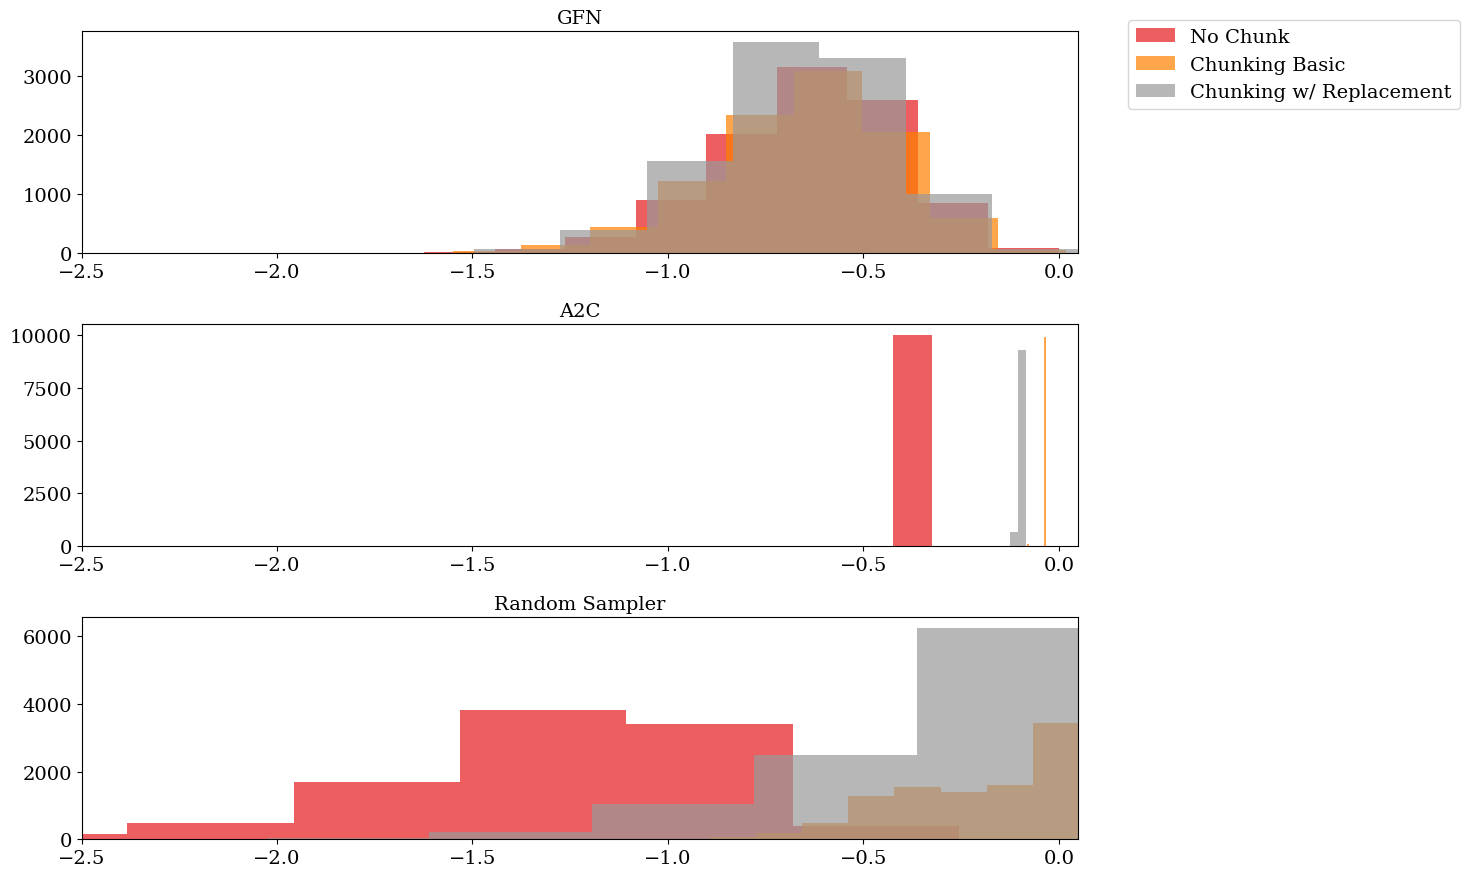

In [11]:
fig, ax = plt.subplots(3,1,figsize=(15,9))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
for i, algo in enumerate(logrewards.keys()):
    for j, chunk_type in enumerate(["No Chunk", 'Chunking Basic', "Chunking w/ Replacement"]):

        ax[i].hist(logrewards[algo][chunk_type], label=chunk_type, color=colors[j], alpha=0.7)
    
    ax[i].set_xlim(-2.5,0.05)
    if i == 0:
        ax[i].legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
    ax[i].set_title(algo)
fig.tight_layout()
plt.show()

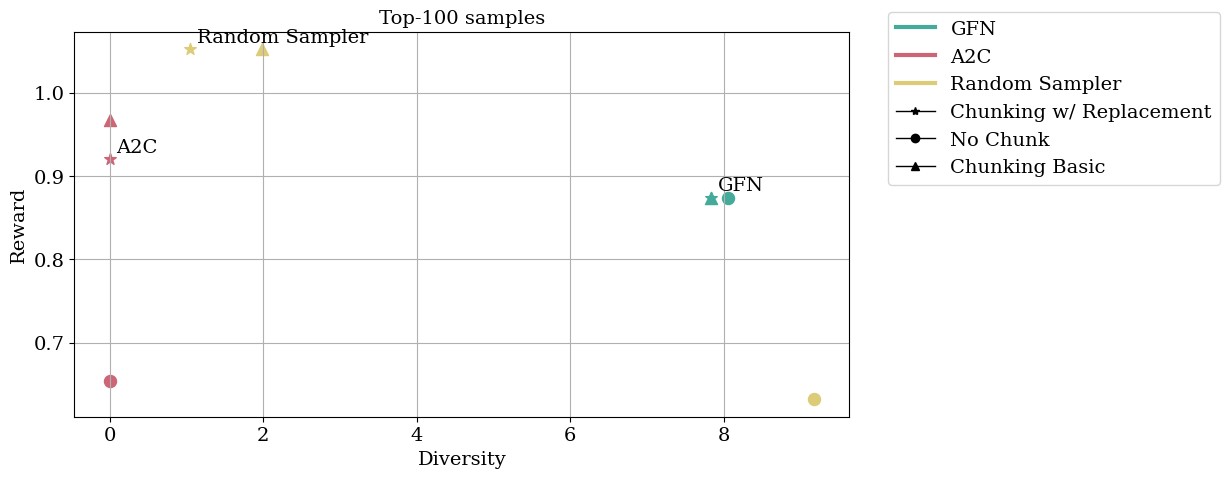

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "No Chunk": "o",
    "Chunking Basic": "^"
}
colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
for i, chunk_type in enumerate(markers.keys()):
    for j, algo in enumerate(logrewards.keys()):
   
        ax.scatter(avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type], s=75, color=colors[algo], marker=markers[chunk_type])
    
    if i == 0:
        for algo in logrewards.keys():
            ax.annotate(
                algo, 
                (avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type]),
                xytext=(5, 5),
                textcoords='offset points')


legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=3, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=3, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=3, linestyle='-', label='Random Sampler'),
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement'),
    Line2D([0], [0], color='black', lw=1, marker='o', label='No Chunk'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

In [13]:
def go_backward(final_state: torch.Tensor, sampler, env):
    """Sample backward trajectories conditioned on inputs.
    Args:
        final_state (torch.Tensor[batch_size, *state_shape]): Final state.
    Return:
        trajectories (torch.Tensor[batch_size, trajectory_length, *state_shape]): Trajectories for each sample in the batch.
        actions (torch.Tensor[batch_size, trajectory_length]): Actions for each sample in the batch.
        dones (torch.Tensor[batch_size, trajectory_length]): Whether the trajectory is done or not.
        state (torch.Tensor[batch_size, *state_shape]): Final state.
    """
    bs = final_state.shape[0]
    device = final_state.device
    state = final_state.clone()
    done = torch.zeros((bs), device=device, dtype=bool)

    # Start unrolling the trajectories
    actions = []
    trajectories = []
    dones = []
    dones.append(torch.ones((bs), device=device, dtype=bool))
    while not done.all():
        logit_pb = get_backward_logits(state, sampler, env)
        backward_mask = env.get_backward_mask(state)
        logit_pb = torch.where(
            backward_mask,
            logit_pb,
            torch.tensor(-1e20, device=device),
        )

        # When no action is available, just fill with uniform because
        # it won't be picked anyway in the backward_step.
        # Doing this avoids having nan when computing probabilities
        logit_pb = torch.where(
            (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
            torch.tensor(0.0),
            logit_pb,
        )
        cat = Categorical(logits=logit_pb)

        act = cat.sample()

        new_state, done = env.backward_step(state, act)

        actions.append(act)
        trajectories.append(state)
        dones.append(done.clone())

        state = new_state.clone()

    trajectories.append(state)

    trajectories = torch.stack(trajectories[::-1], dim=1)
    actions = torch.stack(actions[::-1], dim=1)
    dones = torch.stack(dones[::-1], dim=1)

    return trajectories, actions, dones, final_state

@torch.no_grad
def get_ll(final_states, logreward, sampler, env, n_trajectories):
    bs = final_states.shape[0]
    # Repeat the final_state n_trajectories times
    final_states = repeat(
        final_states, "b ... -> b n ...", n=n_trajectories
    )
    final_states = rearrange(final_states, "b n ... -> (b n) ...")
    logreward = repeat(logreward, "b -> b n", n=n_trajectories)
    trajectories, actions, dones, final_state = go_backward(final_states, sampler, env)
    # Calculate the log likelihood
    log_pf = 0
    log_pb = 0

    for t in range(trajectories.shape[1]):
        state = trajectories[:, t]
        logit_pf = get_forward_logits(state, sampler, env)
        forward_mask = env.get_forward_mask(state)
        logit_pf = torch.where(
            forward_mask,
            logit_pf,
            torch.tensor(-1e20, device=sampler.device),
        )

        if t < trajectories.shape[1] - 1:
            log_pf += (Categorical(logits=logit_pf).log_prob(actions[:, t])) * (
                ~dones[:, t] + 0
            )

        if t > 0:
            logit_pb = get_backward_logits(state, sampler, env)
            backward_mask = env.get_backward_mask(state)

            logit_pb = torch.where(
                backward_mask,
                logit_pb,
                torch.tensor(-1e20, device=sampler.device),
            )

            # When no action is available, just fill with uniform because
            # it won't be picked anyway in the backward_step.
            # Doing this avoids having nan when computing probabilities
            logit_pb = torch.where(
                (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
                torch.tensor(0.0),
                logit_pb,
            )
            log_pb += torch.where(
                dones[:, t] | env.is_initial_state(state),
                torch.tensor(0.0),
                Categorical(logits=logit_pb).log_prob(actions[:, t - 1]),
            )

    log_pb = rearrange(log_pb, "(b n) ... -> b n ...", b=bs).to(final_state.device)
    log_pf = rearrange(log_pf, "(b n) ... -> b n ...", b=bs)
    log_pT = torch.logsumexp(log_pf - log_pb, dim=1) - torch.log(
            torch.tensor(n_trajectories)
        )
    return log_pT, log_pf, log_pb, logreward

In [14]:
logp_Ts = Dict()
losses = Dict()
logrs = Dict()
number_of_trajectories = {
    "No Chunk": 1,
    "Chunking Basic": 10,
    "Chunking w/ Replacement": 10
}
for chunk_type in tqdm(experiments["L14_RNA1"]["GFN"]):
    run_id = experiments["L14_RNA1"]["GFN"][chunk_type][0]["id"]
    
    sampler = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
    env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
    val_sequences = env.data_val.sequences.to(sampler.device)
    val_logr = env.data_val.logrewards.to(sampler.device)
    log_pT, log_pf, log_pb, logr = get_ll(val_sequences, val_logr, sampler, env, number_of_trajectories[chunk_type])
    
    log_pf = rearrange(log_pf, "b n ... -> (b n) ...")
    log_pb = rearrange(log_pb, "b n ... -> (b n) ...")
    logr = rearrange(logr, "b n ... -> (b n) ...")

    losses_ = (sampler.logZ+log_pf - log_pb - logr/sampler.hparams.reward_temperature)**2
    losses_ = losses_.detach().cpu()

    logp_Ts[chunk_type] = log_pT.cpu()
    losses[chunk_type] = losses_.cpu()
    logrs[chunk_type] = logr.cpu()

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_78668/2253628166.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(losses)))


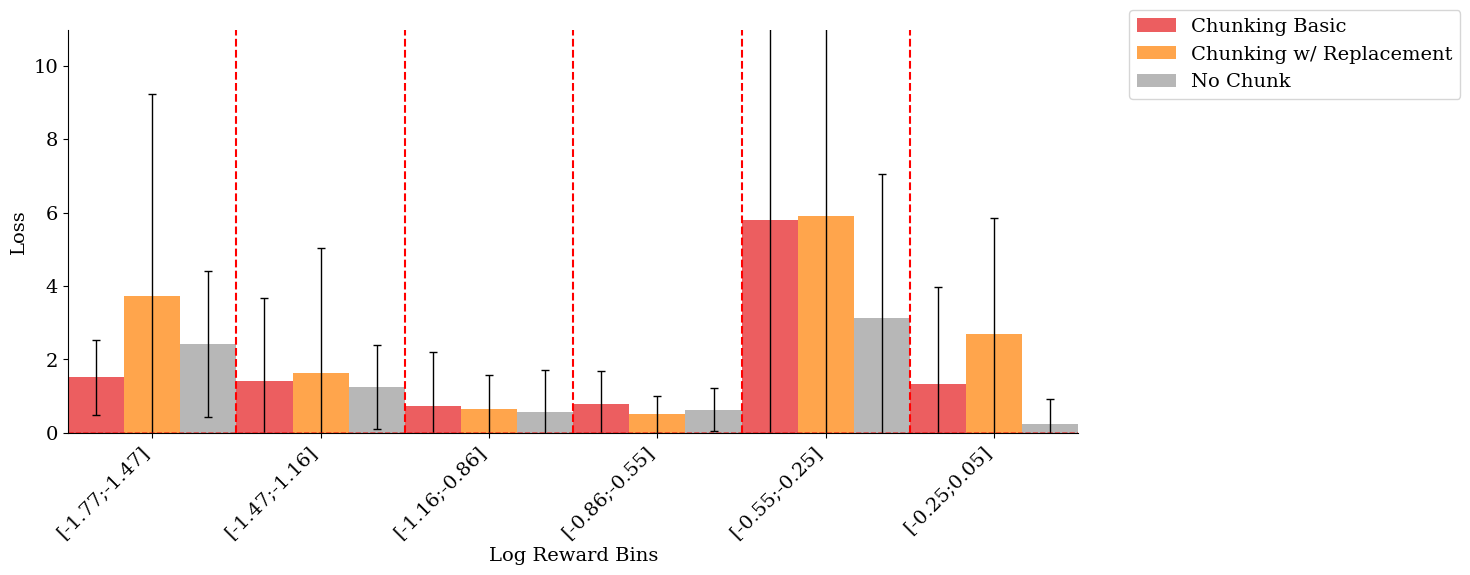

In [43]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
n_bins = 6
gs = fig.add_gridspec(1, 1)

colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(losses)))

# Define error bar styles
error_bar_styles = {
        'ecolor': 'black',        # Error bar color
        'elinewidth': 1,          # Error bar line width
        'capsize': 3,             # Cap size for error bars
        'capthick': 1             # Cap thickness for error bars
    }


for i, chunk_type in enumerate(logp_Ts):
    loss = losses[chunk_type]
    logr = logrs[chunk_type]

    bins = np.linspace(logr.min().cpu(), logr.max().cpu(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bar_width = (bin_centers[1] - bin_centers[0]) / (len(losses))
    digitized = np.digitize(logr.cpu(), bins)

    bin_means = [loss[digitized == i].mean() for i in range(1, len(bins))]
    bin_stds = [loss[digitized == i].std() for i in range(1, len(bins))]

    # Plot loss bar plot
    bar_width = np.diff(bins)[0] / (len(losses) )
    x = bins[:-1] + i * bar_width
    bars = ax.bar(x, bin_means, yerr=bin_stds, width=bar_width, align="edge", 
                        alpha=0.7, color=colors[i], label=chunk_type, error_kw=error_bar_styles)

        
       
    ax.set_xlabel('Log Reward Bins')
    ax.set_ylabel('Loss')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
    
    # Align x-axis of correlation plot with scatter plots
    ax.set_xlim(bins[0], bins[-1])
    
    # Set x-ticks to show bin ranges
    ax.set_xticks(bins[:-1] + np.diff(bins)[0] / 2)
    ax.set_xticklabels([f'[{bins[i]:.2f};{bins[i+1]:.2f}]' for i in range(len(bins)-1)], 
                            rotation=45, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, max(bin_means) + max(bin_stds) * 2)

ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
# Draw dashed lines between bins
dashed_ax =  fig.add_subplot(gs[:, :], sharex = ax)
dashed_ax.patch.set_alpha(0)
dashed_ax.axis("off")
# plot the vertical line
for i in range(n_bins-1):
    dashed_ax.axvline(bins[i+1], c='r', ls='--')
fig.tight_layout()
plt.show()

In [15]:
from scipy.stats import linregress, spearmanr

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def generate_sample_data(n_samples=1000, n_models=3):
    """Generate sample data for multiple models."""
    rewards = np.random.uniform(0, 10, n_samples)
    other_quantities = {
        f'Model {i+1}': rewards * np.sin(rewards + i) + np.random.normal(0, 2, n_samples)
        for i in range(n_models)
    }
    return rewards, other_quantities

def compute_correlation(x, y):
    """Compute Pearson correlation coefficient."""
    return stats.pearsonr(x, y)[0]

def plot_scatter_and_correlation_per_reward_bin(rewards, other_quantities, n_bins=5):
    """Plot aligned side-by-side scatter plots and multi-model correlation bar plot for each reward bin."""
    bins = np.linspace(rewards.min(), rewards.max(), n_bins + 1)
    digitized = np.digitize(rewards, bins)
    
    models = list(other_quantities.keys())
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))
    
    correlations = {model: [] for model in models}
    for i in range(1, len(bins)):
        mask = digitized == i
        for model in models:
            if np.sum(mask) > 2:
                corr = compute_correlation(rewards[mask], other_quantities[model][mask])
            else:
                corr = np.nan
            correlations[model].append(corr)
    
    # Create subplots: n_bins for scatter plots in one row, 1 for correlation bar plot
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, n_bins, height_ratios=[3, 1], hspace=0.3, wspace=0.05)
    
    scatter_axs = [fig.add_subplot(gs[0, i]) for i in range(n_bins)]
    corr_ax = fig.add_subplot(gs[1, :])
    
    fig.suptitle('Scatter Plots and Correlations per Reward Bin for Multiple Models', fontsize=16)
    
    # Plot scatter plots
    for i, ax in enumerate(scatter_axs):
        mask = digitized == i + 1
        for j, model in enumerate(models):
            ax.scatter(rewards[mask], other_quantities[model][mask], alpha=0.5, color=colors[j], label=model if i == 0 else "")
        ax.set_xlim(bins[i], bins[i+1])
        ax.set_ylim(min(q.min() for q in other_quantities.values()), 
                    max(q.max() for q in other_quantities.values()))
        if i == 0:
            ax.set_ylabel('$\log{p^T}$')
        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
        if i < n_bins - 1:
            ax.spines['right'].set_visible(False)
        
        ax.spines["bottom"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xticks([])
    
    # Plot correlation bar plot
    bar_width = np.diff(bins)[0] / (len(models) + 1)
    for j, model in enumerate(models):
        x = bins[:-1] + j * bar_width
        bars = corr_ax.bar(x, correlations[model], width=bar_width, align="edge", 
                           alpha=0.7, color=colors[j], label=model)
        
       
    corr_ax.set_xlabel('Log Reward Bins')
    corr_ax.set_ylabel('Correlation')
    corr_ax.set_ylim(-1.1, 1.1)
    corr_ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
    corr_ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
    
    # Align x-axis of correlation plot with scatter plots
    corr_ax.set_xlim(bins[0], bins[-1])
    
    # Set x-ticks to show bin ranges
    corr_ax.set_xticks(bins[:-1] + np.diff(bins)[0] / 2)
    corr_ax.set_xticklabels([f'[{bins[i]:.2f};{bins[i+1]:.2f}]' for i in range(len(bins)-1)], 
                            rotation=45, ha='right')
    corr_ax.spines['top'].set_visible(False)
    
    
    # Draw dashed lines between bins
    dashed_ax =  fig.add_subplot(gs[:, :], sharex = corr_ax)
    dashed_ax.patch.set_alpha(0)
    dashed_ax.axis("off")
    # plot the vertical line
    for i in range(n_bins-1):
        dashed_ax.axvline(bins[i+1], c='r', ls='--')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2081057/1313635349.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))
/tmp/ipykernel_2081057/1313635349.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


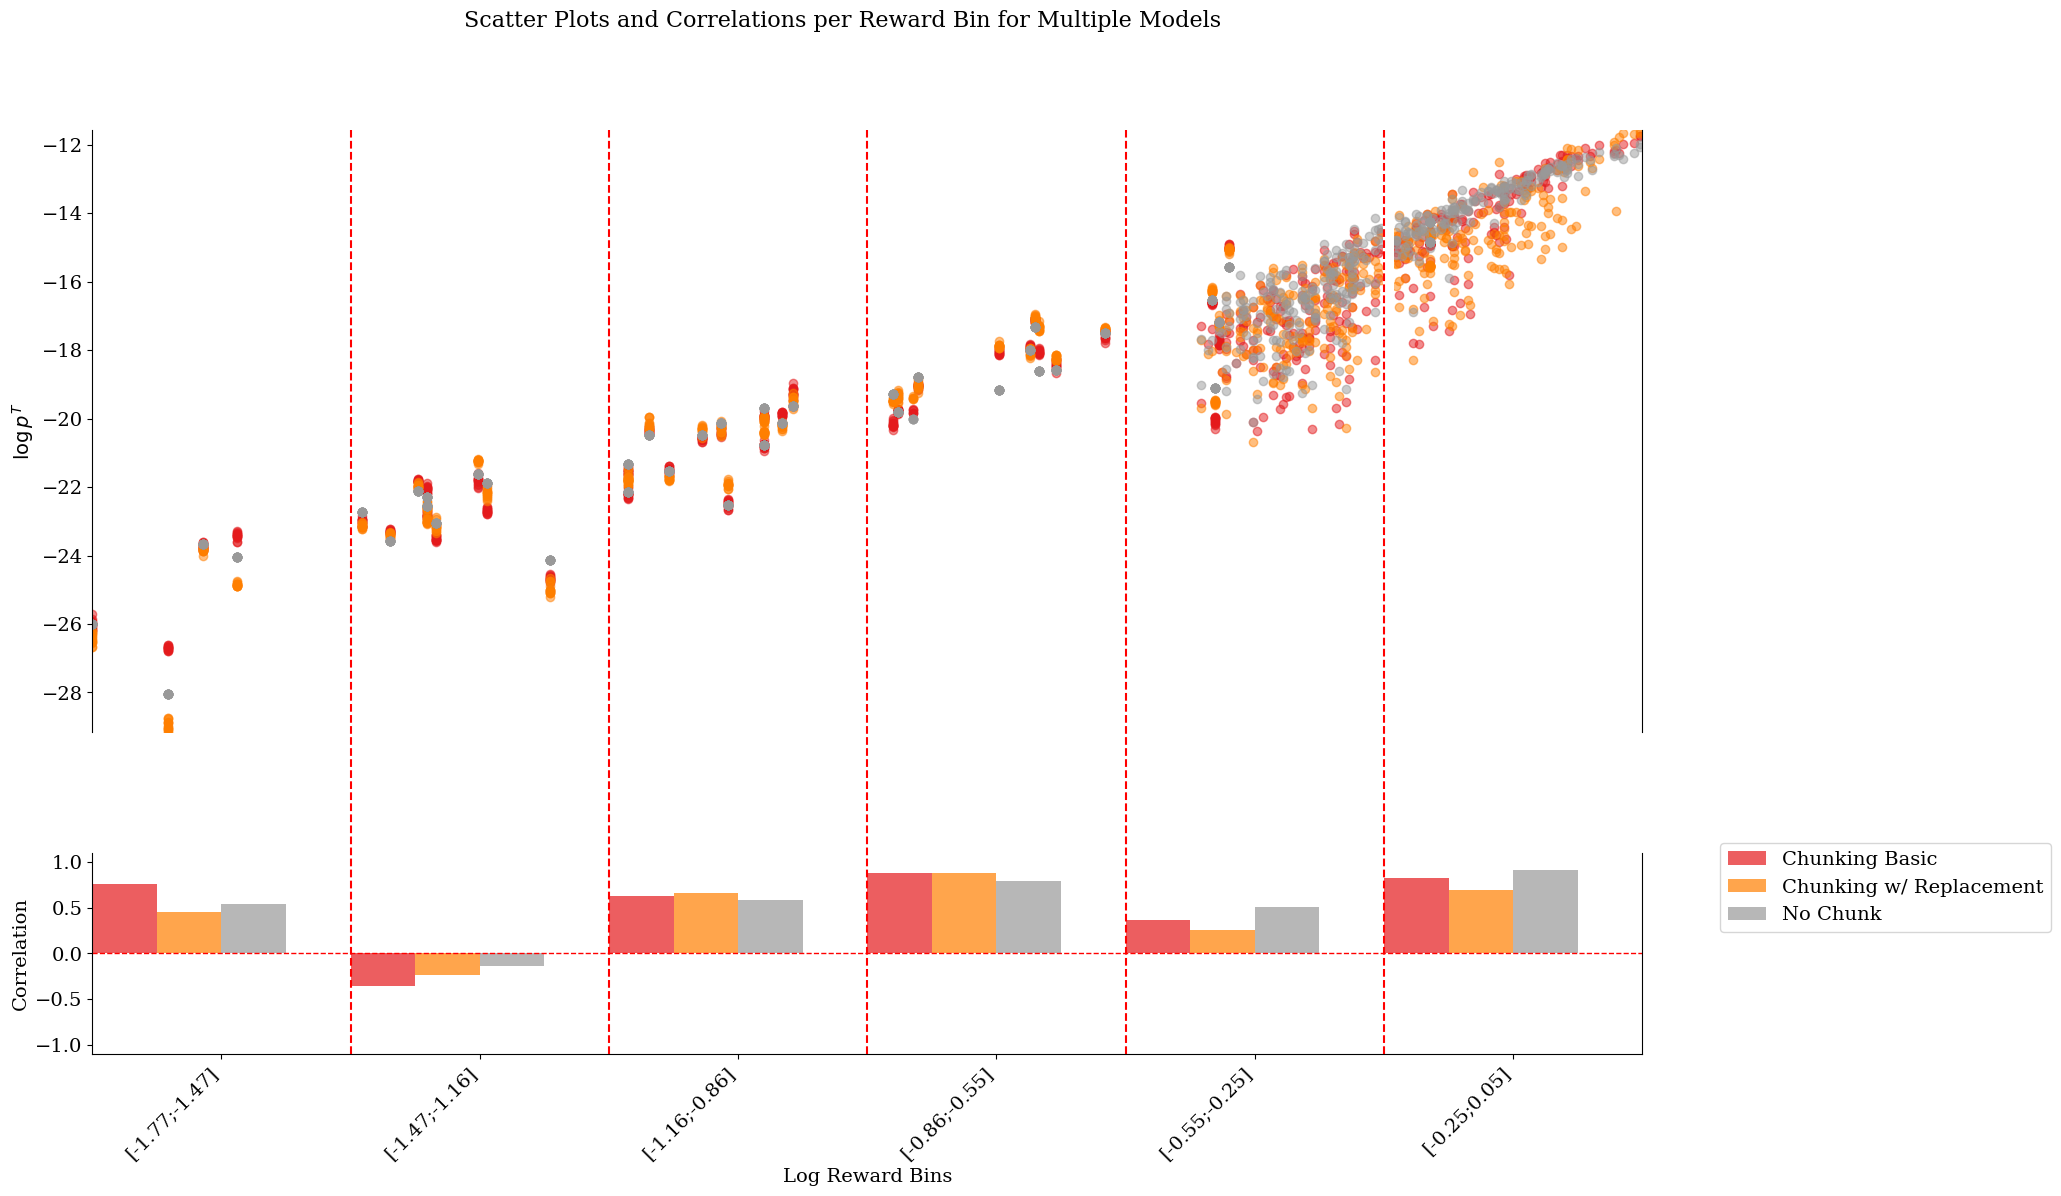

In [53]:
plot_scatter_and_correlation_per_reward_bin(logrs["No Chunk"], logp_Ts, n_bins=6)

In [58]:
libraries = Dict()
for algorithm in tqdm(experiments["L14_RNA1"]):
    for chunk_type in experiments["L14_RNA1"][algorithm]:
        if chunk_type != "No Chunk":
            run = experiments["L14_RNA1"][algorithm][chunk_type][0]
            run_id = run["id"]
            lib = torch.load(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/library_249.pt")
            libraries[algorithm][chunk_type] = lib

  0%|          | 0/3 [00:00<?, ?it/s]

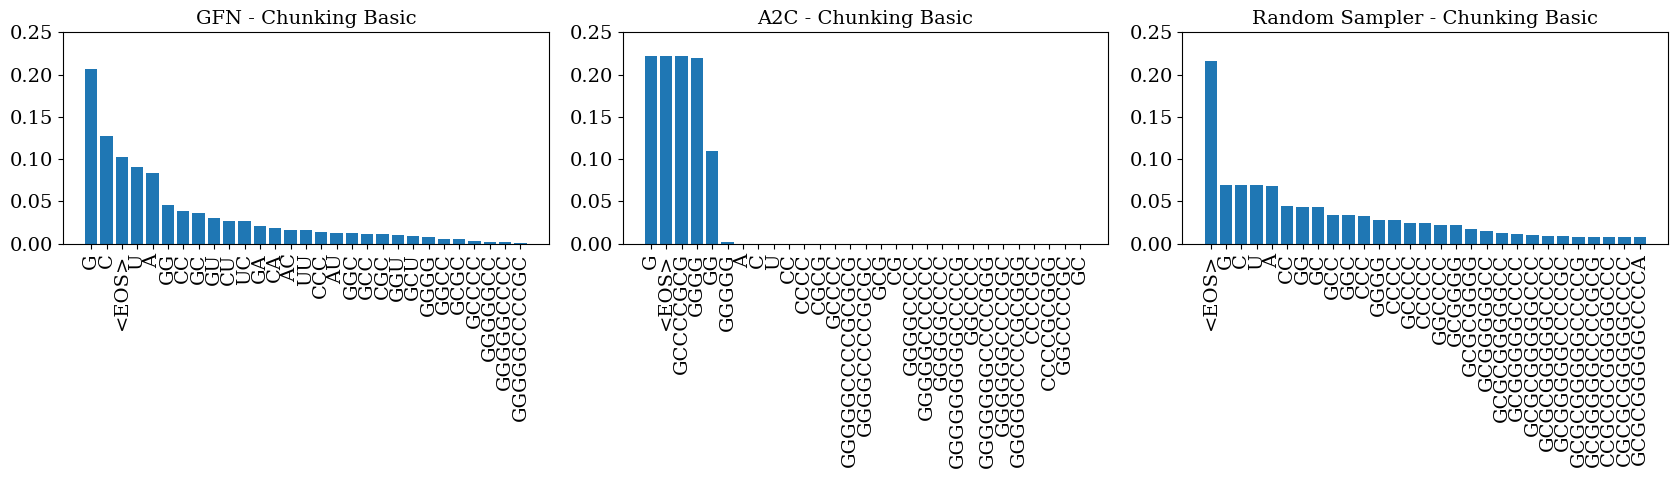

In [74]:
fig, ax = plt.subplots(1,3,figsize=(17,5))
for i, algo in enumerate(libraries):
    lib_ = sorted(libraries[algo]["Chunking Basic"], key=lambda x: x[0], reverse=True)
    lib_Z = sum([a[0] for a in lib_])
    ax[i].bar([a[1] for a in lib_], [a[0].item()/lib_Z for a in lib_])
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"{algo} - Chunking Basic")
    ax[i].set_ylim(0, 0.25)
fig.tight_layout()

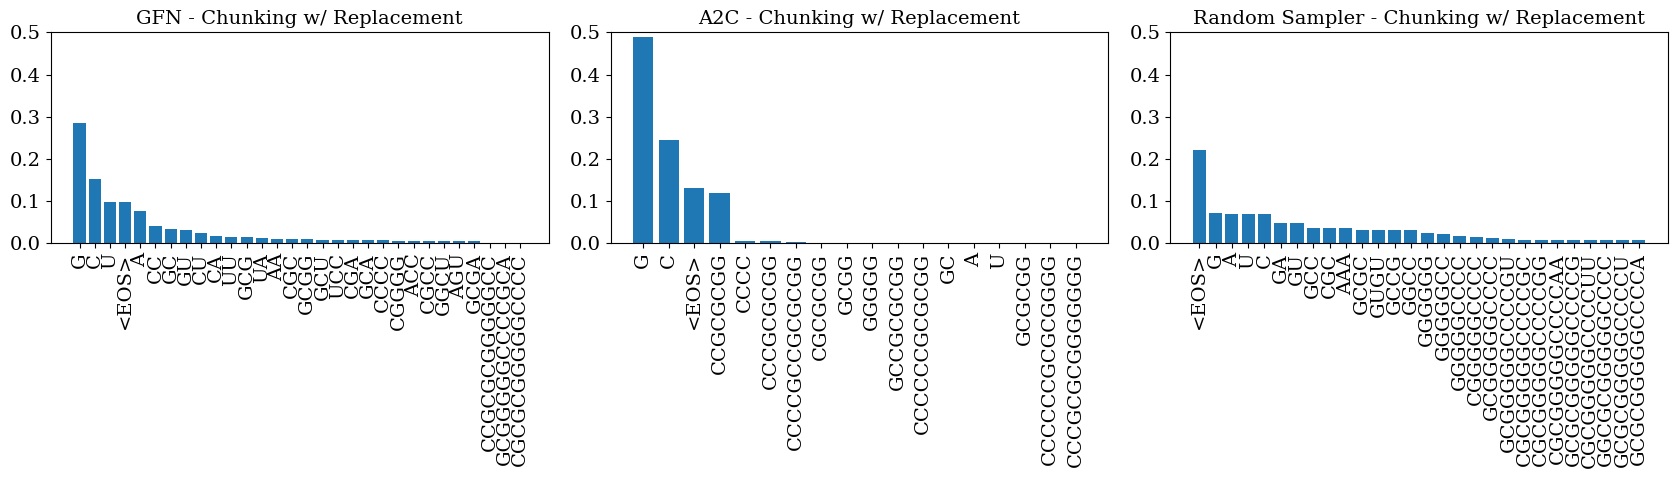

In [73]:
fig, ax = plt.subplots(1,3,figsize=(17,5))
for i, algo in enumerate(libraries):
    lib_ = sorted(libraries[algo]["Chunking w/ Replacement"], key=lambda x: x[0], reverse=True)
    lib_Z = sum([a[0] for a in lib_])
    ax[i].bar([a[1] for a in lib_], [a[0].item()/lib_Z for a in lib_])
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"{algo} - Chunking w/ Replacement")
    ax[i].set_ylim(0, 0.5)
fig.tight_layout()

In [100]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "chunking_strategy"})
columns = ["_step", 'train/num_modes', "train/loss_epoch", 'train/logreward', 'trainer/global_step']

# Group runs by algorithm and then length
experiments = Dict()
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    summary["id"] = run.id
    config = run.config
    
    algo = config["algo"]["_target_"].lower()
    task = config["environment"]["task"]

    if "loss" in algo:
        algorithm = "Adaptive GFN"
    elif "tbgfn" in algo:
        algorithm = "GFN"
    else:
        raise Exception("can't recognize algorithm")
    
    if "chunk" not in name:
        chunk_type = "No Chunk"
    elif "chunk_replacement" in name:
        chunk_type = "Chunking w/ Replacement"
    elif "chunk" in name:
        chunk_type = "Chunking Basic"

    if len(experiments[task][algorithm][chunk_type]) == 0:
        experiments[task][algorithm][chunk_type] = [summary]
    else:
        experiments[task][algorithm][chunk_type].append(summary)

  0%|          | 0/12 [00:00<?, ?it/s]

In [99]:
experiments["L14_RNA1"]["GFN"]["Chunking Basic"]

[{'id': '4982298'}, {'id': '4982289'}, {'id': '4982280'}]

KeyError: 'trainer/global_step'

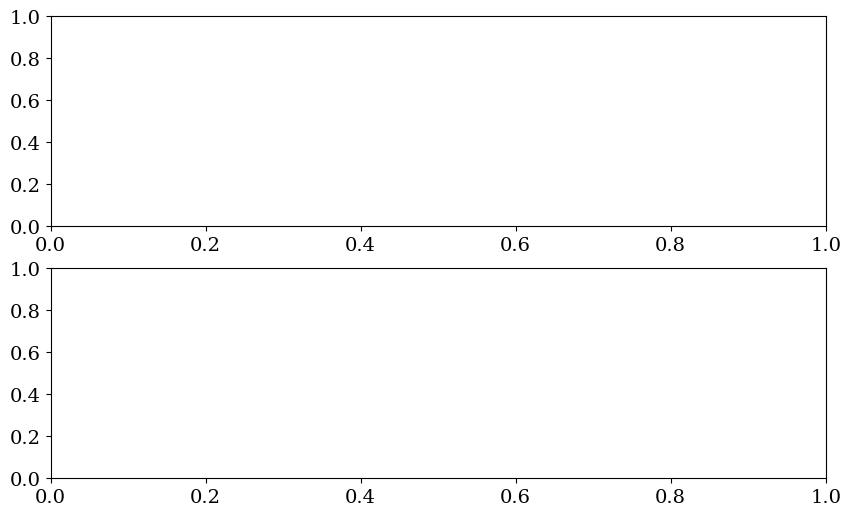

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):
 
        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
        
        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)

        ax[i].set_ylim(0,130)
        
        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")
        
        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Number of Modes")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


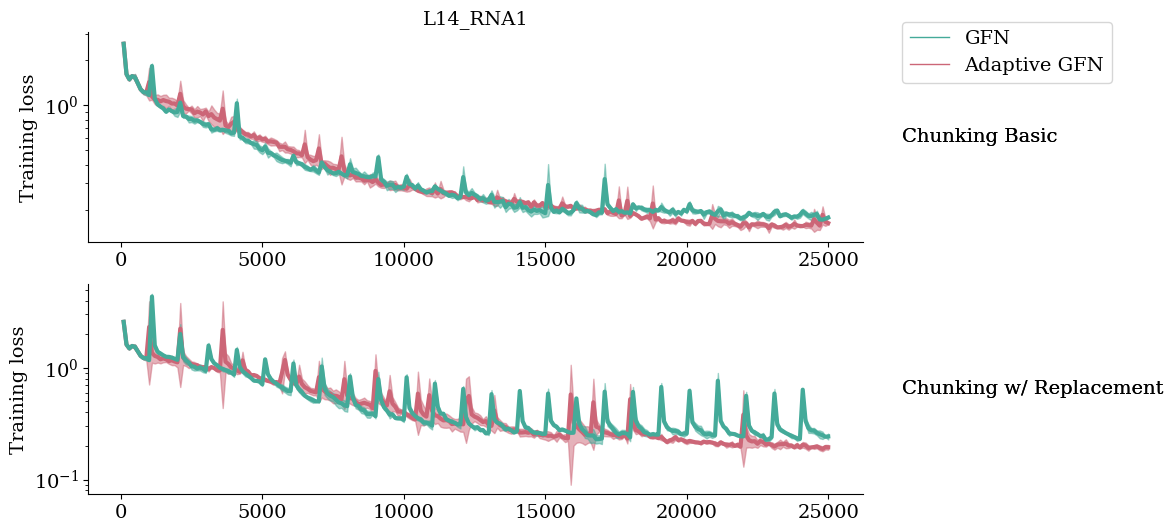

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):
 
        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/loss_epoch", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].semilogy(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
        
        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)

        
        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")
        
        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Training loss")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


KeyError: 'trainer/global_step'

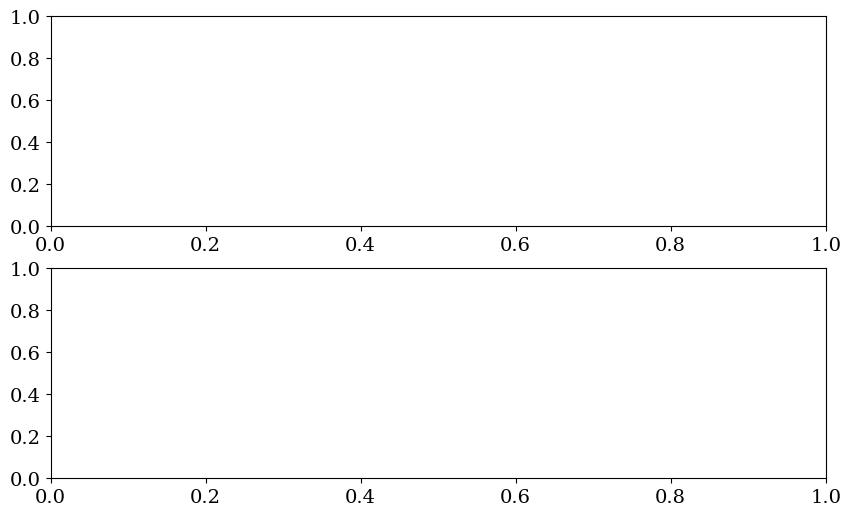

In [89]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):
 
        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "val/correlation", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].semilogy(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)
        
        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)

        
        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")
        
        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Validation loss")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
